In [69]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, norm
import math
import itertools

Define The Halving Dates and the Regions Of Interest Around Them

In [3]:
halving_dates=[
datetime.datetime.strptime('2012/11/28', '%Y/%m/%d'),
datetime.datetime.strptime('2016/07/09', '%Y/%m/%d'),
datetime.datetime.strptime('2020/05/11', '%Y/%m/%d'),
datetime.datetime.strptime('2024/04/19', '%Y/%m/%d')
]
halving_dates

[datetime.datetime(2012, 11, 28, 0, 0),
 datetime.datetime(2016, 7, 9, 0, 0),
 datetime.datetime(2020, 5, 11, 0, 0),
 datetime.datetime(2024, 4, 19, 0, 0)]

In [4]:
halving_regions = [(x - datetime.timedelta(days=180), x + datetime.timedelta(days=180)) for x in halving_dates]
halving_regions

[(datetime.datetime(2012, 6, 1, 0, 0), datetime.datetime(2013, 5, 27, 0, 0)),
 (datetime.datetime(2016, 1, 11, 0, 0), datetime.datetime(2017, 1, 5, 0, 0)),
 (datetime.datetime(2019, 11, 13, 0, 0), datetime.datetime(2020, 11, 7, 0, 0)),
 (datetime.datetime(2023, 10, 22, 0, 0),
  datetime.datetime(2024, 10, 16, 0, 0))]

Load The Data

In [6]:
df = pd.read_csv('data/bitcoin_2010-07-17_2024-05-23.csv')
df = df[['Start', 'Close']]
df = df.set_index('Start')
df = df.astype(float)
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df.head()

,Close
Start,
2010-07-17,0.0500
2010-07-18,0.0858
2010-07-19,0.0808
2010-07-20,0.0747
2010-07-21,0.0792


In [7]:
df['mean_15'] = df['Close'].rolling(window=15).mean().fillna(0)
df['std_15'] = df['Close'].rolling(window=15).std().fillna(0)
df.head(100)


,Close,mean_15,std_15
Start,,,
2010-07-17,0.0500,0.000000,0.000000
2010-07-18,0.0858,0.000000,0.000000
2010-07-19,0.0808,0.000000,0.000000
2010-07-20,0.0747,0.000000,0.000000
2010-07-21,0.0792,0.000000,0.000000
...,...,...,...
2010-10-20,0.0990,0.094020,0.012774
2010-10-21,0.1070,0.096967,0.009813
2010-10-22,0.1025,0.099333,0.005323


Text(0.5, 1.0, 'BTC Historical Price Chart')

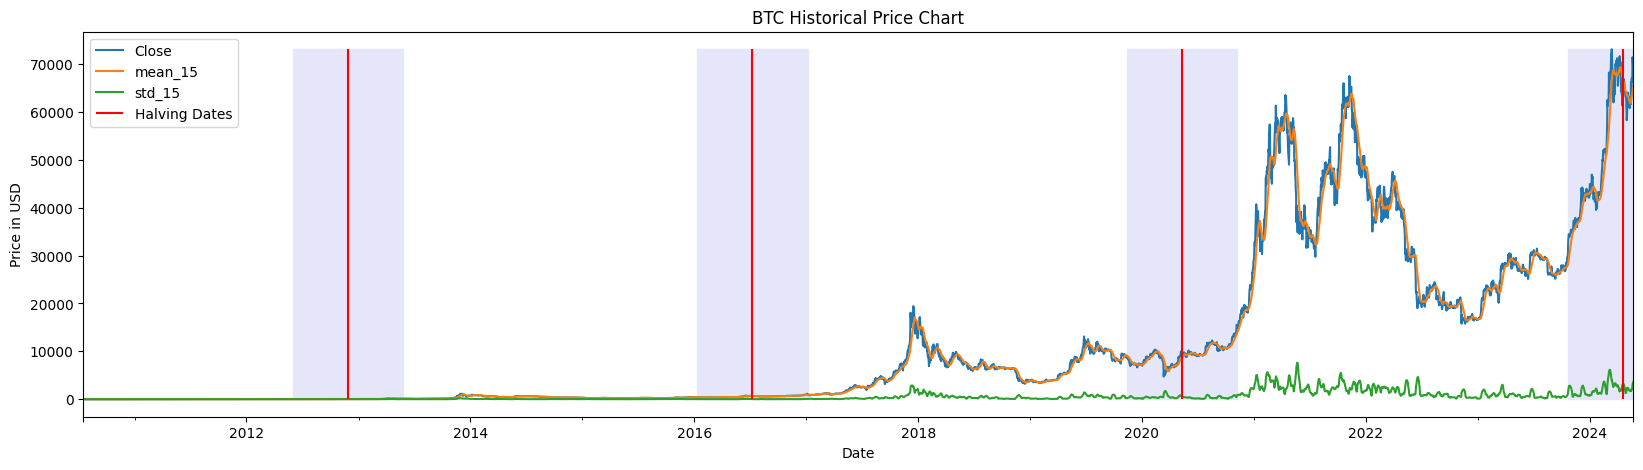

In [8]:
ax = df.plot(figsize=(20,5))
ax.vlines(halving_dates, 0, df['Close'].max(), colors='r', label='Halving Dates')
for item in halving_regions:
    ax.fill_between(item, 0 , df['Close'].max(), color='lavender',)
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('BTC Historical Price Chart')

Divide into 8 segments: 4 segments whitin 1 year of the halvings, and the 4 segments in between them

In [9]:
halving_data = []
nonhalving_data = []

for idx, item in enumerate(halving_regions):
    # halving_data.append(df.loc[])
    halving_data.append(df.loc[item[0] : item[1]])
    if idx == 0:
        nonhalving_data.append(df.loc[ : item[0]])
    else: 
        nonhalving_data.append(df.loc[halving_regions[idx -1][1] : item[0]])

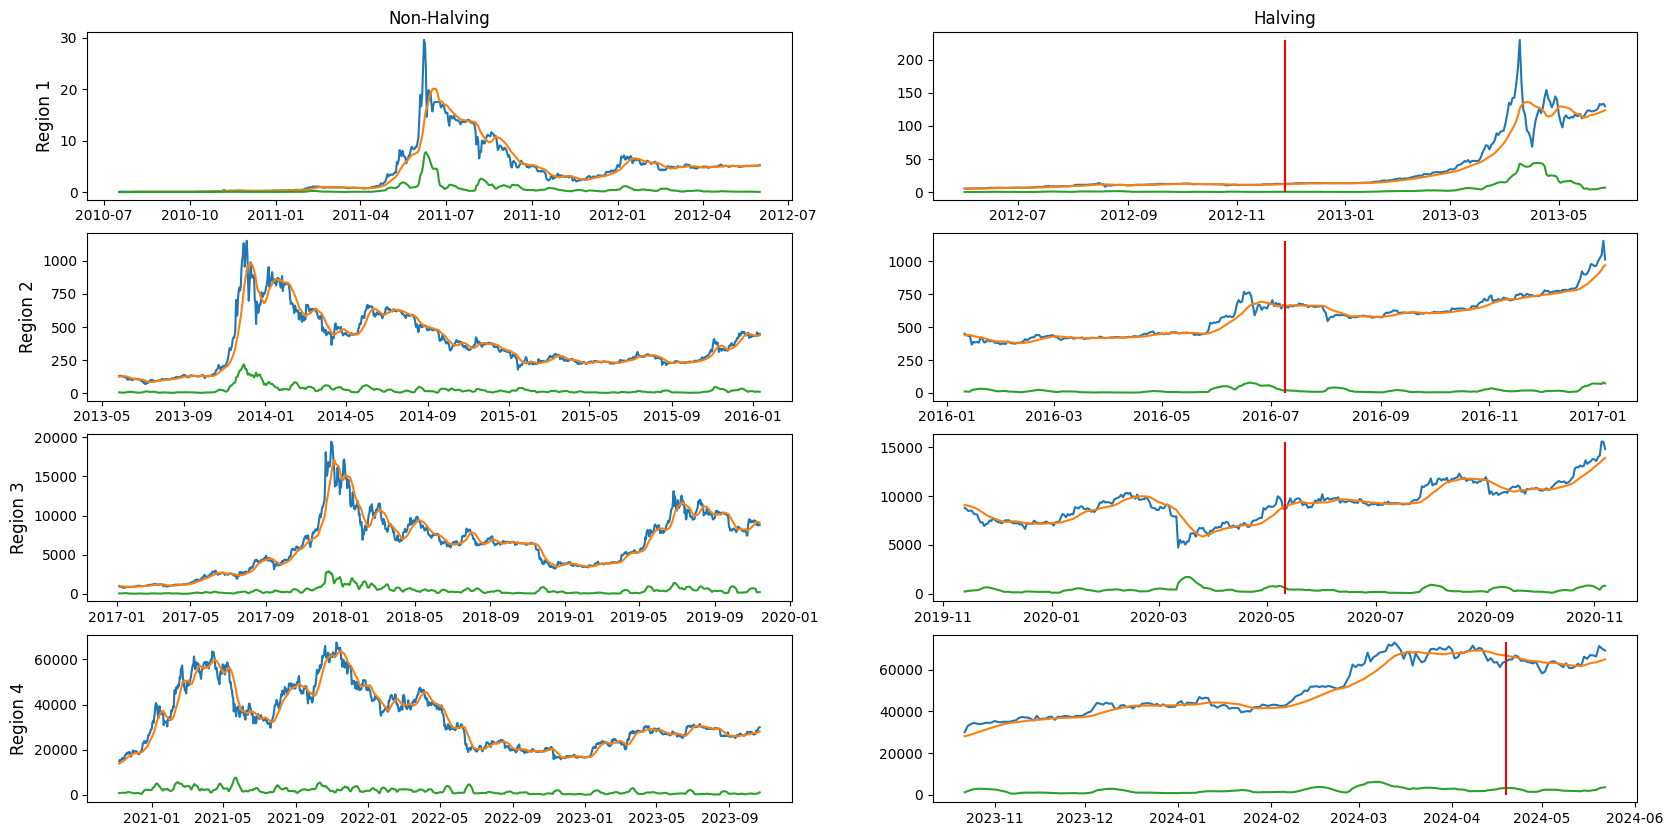

In [10]:
ctr = 1
fig, ax = plt.subplots(4,2, figsize=(20,10))
for nhd, hd in zip(nonhalving_data, halving_data):
    ax[ctr -1][0].plot(nhd)
    ax[ctr -1][1].plot(hd)
    ax[ctr -1][1].vlines(halving_dates[ctr - 1], 0, hd['Close'].max(), colors='r', label='Halving Date')
    ctr += 1
ax[0][0].set_title('Non-Halving')
ax[0][1].set_title('Halving')
for i in range(4):
    ax[i][0].set_ylabel(f'Region {i+1}', rotation=90, size='large')


Analysis on Volatility (Standard Deviation)

Text(0.5, 0.98, '15-Day Volatility')

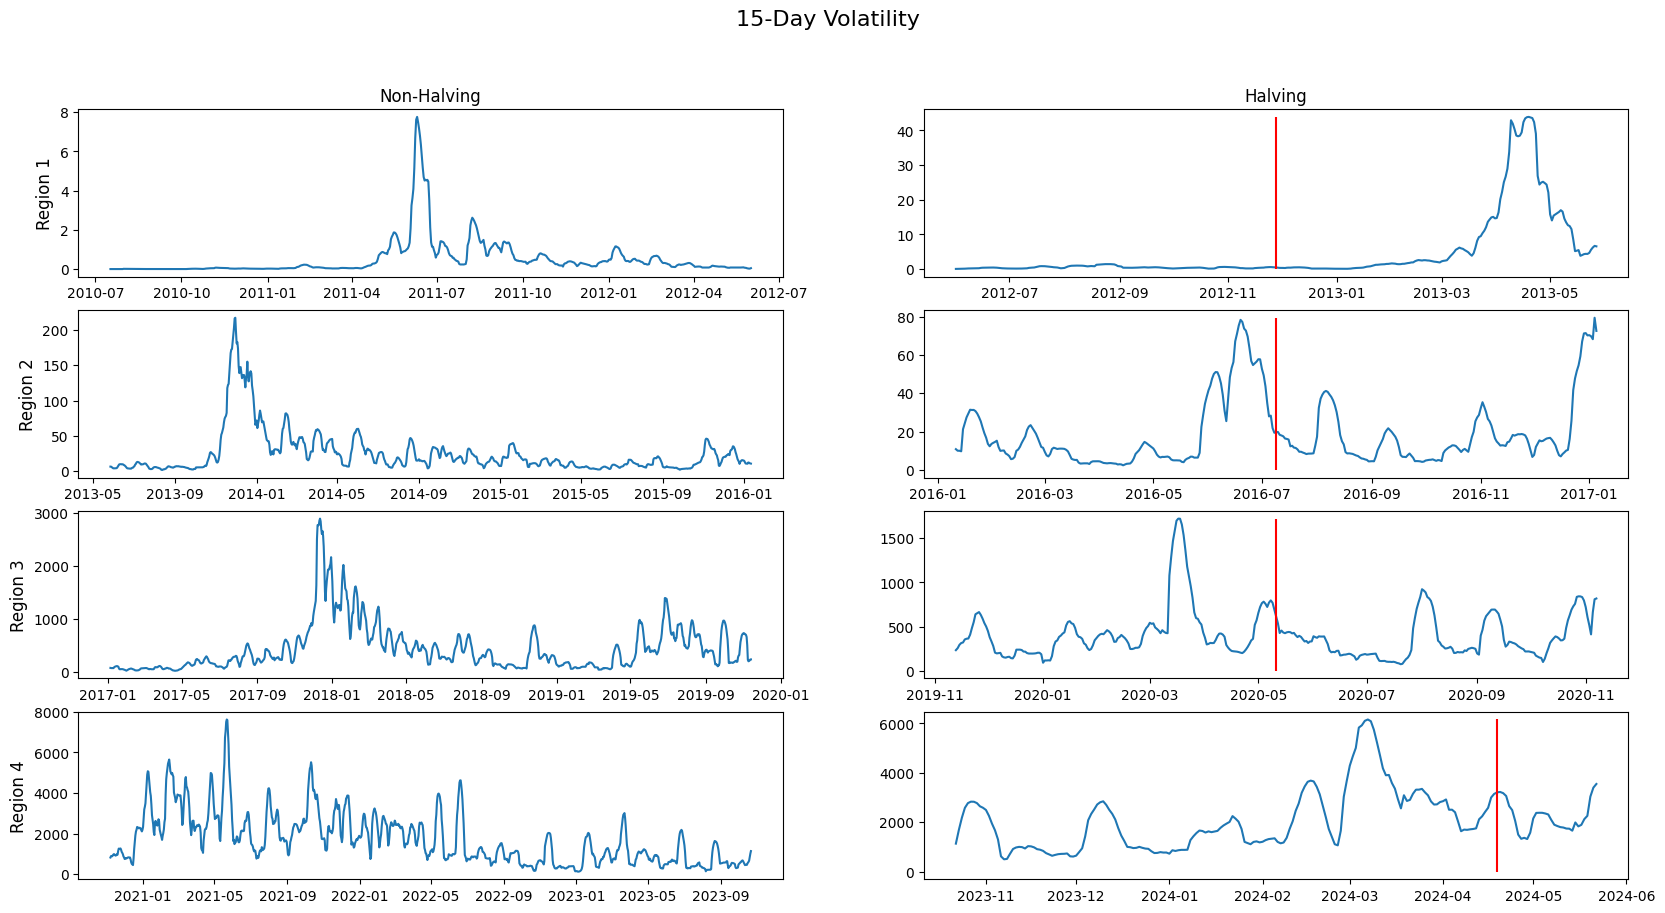

In [178]:
ctr = 1
fig, ax = plt.subplots(4,2, figsize=(20,10))
for nhd, hd in zip(nonhalving_data, halving_data):
    ax[ctr -1][0].plot(nhd['std_15'])
    ax[ctr -1][1].plot(hd['std_15'])
    ax[ctr -1][1].vlines(halving_dates[ctr - 1], 0, hd['std_15'].max(), colors='r', label='Halving Date')
    ctr += 1
ax[0][0].set_title('Non-Halving')
ax[0][1].set_title('Halving')
for i in range(4):
    ax[i][0].set_ylabel(f'Region {i+1}', rotation=90, size='large')

fig.suptitle('15-Day Volatility',fontsize=16)

Text(0.5, 0.98, '15-Day Volatility Distribution')

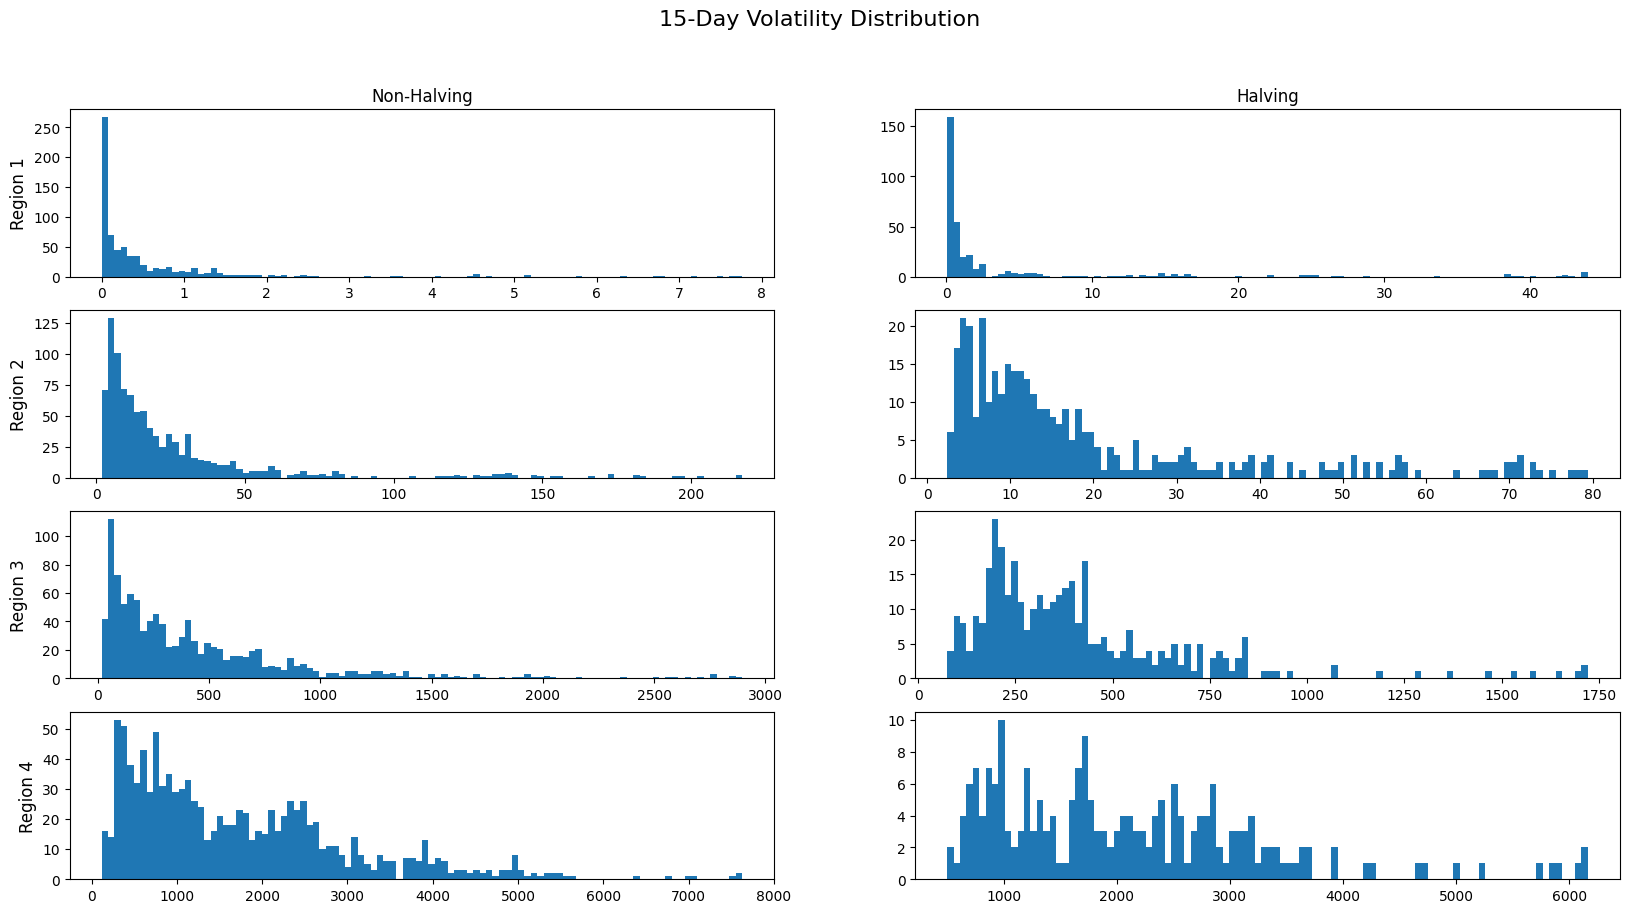

In [179]:
ctr = 1
fig, ax = plt.subplots(4,2, figsize=(20,10))
for nhd, hd in zip(nonhalving_data, halving_data):
    ax[ctr -1][0].hist(nhd['std_15'], bins=100)
    ax[ctr -1][1].hist(hd['std_15'], bins=100)
    ctr += 1
ax[0][0].set_title('Non-Halving')
ax[0][1].set_title('Halving')
for i in range(4):
    ax[i][0].set_ylabel(f'Region {i+1}', rotation=90, size='large')
fig.suptitle('15-Day Volatility Distribution',fontsize=16)

A-B Testing Between Regions<br>
Alternative Hypothesis: The halvings have an effect on the 15-day volatility (standard deviation) of BTC.<br>
Null Hypothesis: The halvings have no effect

In [68]:
p_halving_hat= []
p_nonhalving_hat = []

for item in halving_data:
    p_halving_hat.append((np.sum(item['std_15'].to_numpy())/len(item.index)/item['std_15'].max(),len(item.index)))

for item in nonhalving_data:
    p_nonhalving_hat.append((np.sum(item['std_15'].to_numpy())/len(item.index)/item['std_15'].max(),len(item.index)))

print(p_halving_hat)
print(p_nonhalving_hat)

[(0.10382449320253768, 361), (0.23682707088962737, 361), (0.2345585372823139, 361), (0.3391811217312419, 214)]
[(0.06476702570862912, 686), (0.11352377613586609, 960), (0.14934067445121985, 1043), (0.2247809135579454, 1080)]


SE of Halving Data = 0.009404
SE of Nonhalving Data = 0.016077
Pooled SE      = 0.018625
t-Statistic    = 2.097063


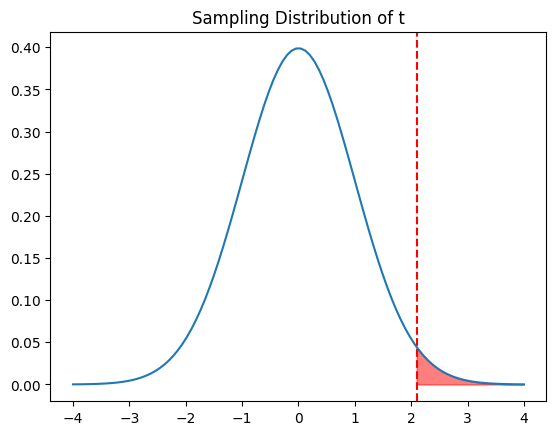

p-value = 0.018114
p-value less than alpha! Reject H0.


SE of Halving Data = 0.010244
SE of Nonhalving Data = 0.022407
Pooled SE      = 0.024637
t-Statistic    = 5.004750


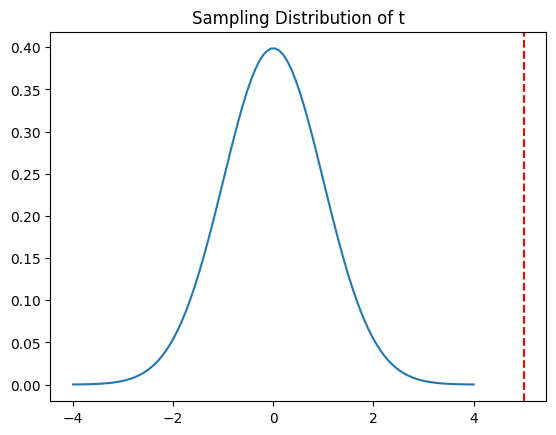

p-value = 0.000000
p-value less than alpha! Reject H0.


SE of Halving Data = 0.011042
SE of Nonhalving Data = 0.022332
Pooled SE      = 0.024913
t-Statistic    = 3.420661


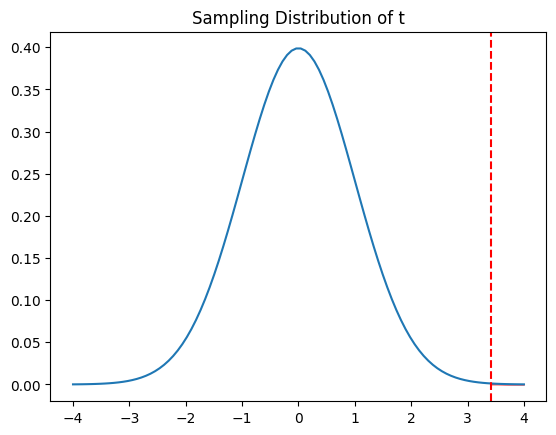

p-value = 0.000321
p-value less than alpha! Reject H0.


SE of Halving Data = 0.012708
SE of Nonhalving Data = 0.032439
Pooled SE      = 0.034839
t-Statistic    = 3.283644


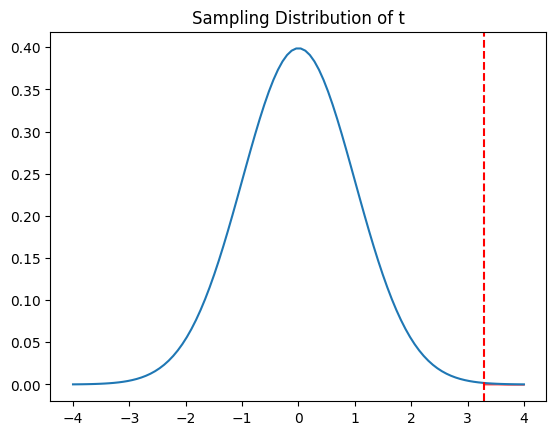

p-value = 0.000526
p-value less than alpha! Reject H0.




In [153]:
alpha = 0.05
p_values = {}
for i in range(len(p_halving_hat)):
    p_nh_hat = p_nonhalving_hat[i][0]
    n_nh = p_nonhalving_hat[i][1]
    p_h_hat = p_halving_hat[i][0]
    n_h = p_halving_hat[i][1]
    se1 = np.sqrt(p_nh_hat*(1-p_nh_hat)/(n_nh-1)) # Standard error of sample 1 (control group)
    se2 = np.sqrt(p_h_hat*(1-p_h_hat)/(n_h-1)) # Standard error of sample 2
    pooled_se = np.sqrt(se1**2 + se2**2) # If we assume independent samples, the total variance is just the sum
    t_stat = (p_h_hat - p_nh_hat)/pooled_se # t-statistic (looks like a z-score but has t distribution instead of normal)
    print(f'SE of Halving Data = {se1:.6f}')
    print(f'SE of Nonhalving Data = {se2:.6f}')
    print(f'Pooled SE      = {pooled_se:.6f}')
    print(f't-Statistic    = {t_stat:.6f}')

    df = n_nh + n_h - 2 # Degrees of freedom, we subtract 2 because we used 2 estimates (se1 & se2)
                            # It is the number of values in the final calculation of a statistic that are free to vary

    # Plot distribution of null hypothesis
    x = np.linspace(-4, 4, 100)
    plt.plot(x, t.pdf(x, df))
    plt.title('Sampling Distribution of t')

    plt.axvline(t_stat, c='red', linestyle='dashed')
    x_shade = np.arange(t_stat, 4, 0.0001)
    plt.fill_between(x_shade, t.pdf(x_shade, df), color='red', alpha=0.5)

    plt.show()
    p_value = 1 - t.cdf(abs(t_stat), df)
    p_values[i]=p_value
    print(f'p-value = {p_value:.6f}')
    if p_value <= alpha:
        print(f'p-value less than alpha! Reject H0.\n\n')
    else:
        print(f'p-value greater than alpha! Cannot Reject H0.\n\n')

Holm's Step-Down Procedure

In [154]:
# print(p_values)
df_stat=pd.DataFrame()
df_stat['region']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
df_stat['reject'] = df_stat['p_value'] < df_stat['L_thresholds']
print(df_stat)

   region       p_value  L_thresholds  reject
1       1  3.174465e-07      0.012500    True
2       2  3.213212e-04      0.016667    True
3       3  5.260874e-04      0.025000    True
0       0  1.811395e-02      0.050000    True


We conclude that the halving had a statistically significant effect on volatility during the period of the halvings.

In [116]:
p_halving_std = []
p_nonhalving_std = []


for item in halving_data:
    p_halving_std.append((np.std(item['std_15'].to_numpy()),len(item.index)))

for item in nonhalving_data:
    p_nonhalving_std.append((np.std(item['std_15'].to_numpy()),len(item.index)))

print(p_halving_std)
print(p_nonhalving_std)

[(9.561227930365078, 361), (17.633608316904954, 361), (276.7250763382907, 361), (1178.4783239179994, 214)]
[(0.9984743488449, 686), (31.40799313575192, 960), (453.08578897503037, 1043), (1288.43307617764, 1080)]


SE      = 0.504664
Z-score    = 0.077393


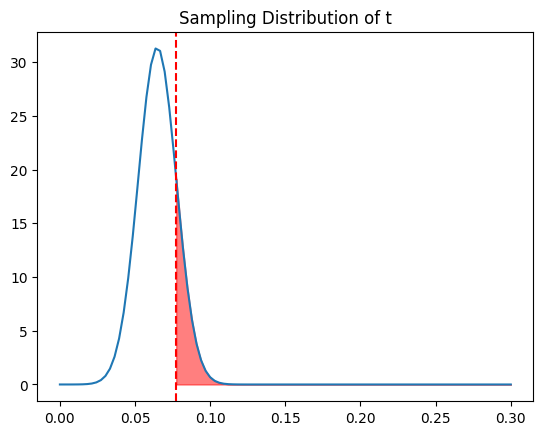

p-value = 0.160225
p-value greater than alpha! Cannot Reject H0.


SE      = 1.374375
Z-score    = 0.089716


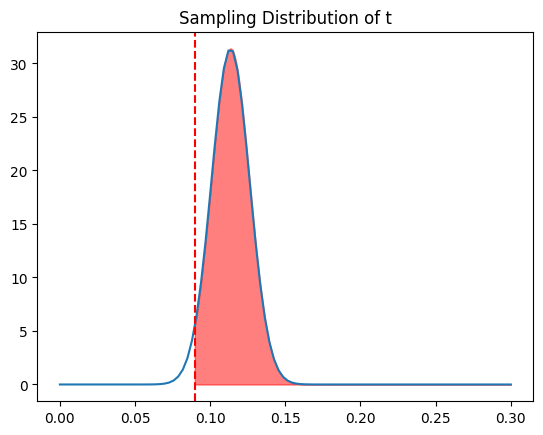

p-value = 0.969496
p-value greater than alpha! Cannot Reject H0.


SE      = 20.222446
Z-score    = 0.004214


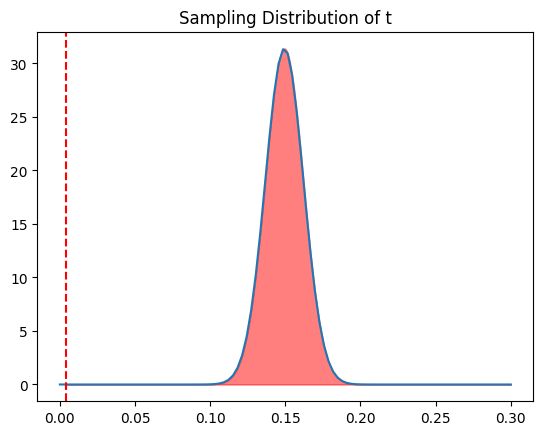

p-value = 1.000000
p-value greater than alpha! Cannot Reject H0.


SE      = 89.592769
Z-score    = 0.001277


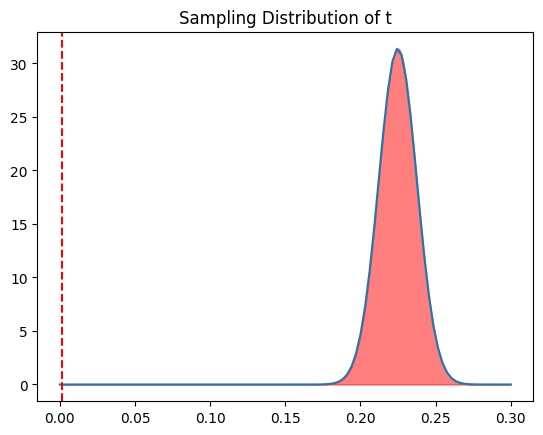

p-value = 1.000000
p-value greater than alpha! Cannot Reject H0.




In [135]:
alpha = 0.05
p_values = {}
for i in range(len(p_halving_hat)):
    p_nh_hat = p_nonhalving_hat[i][0]
    n_nh = p_nonhalving_hat[i][1]
    p_h_hat = p_halving_hat[i][0]
    n_h = p_halving_hat[i][1]
    p_nh_std = p_nonhalving_std[i][0]
    p_h_std = p_halving_std[i][0]
    se = math.sqrt((p_nh_std ** 2) / n_nh + (p_h_std ** 2) / n_h)
    z_score = (p_h_hat - p_nh_hat)/se 

    print(f'SE      = {se:.6f}')
    print(f'Z-score    = {z_score:.6f}')

    # Plot distribution of null hypothesis
    x = np.linspace(0, 0.3, 100)
    plt.plot(x, norm.pdf(x, loc=p_nh_hat, scale=se1))
    plt.title('Sampling Distribution of t')

    plt.axvline(z_score, c='red', linestyle='dashed')
    x_shade = np.arange(z_score, 0.3, 0.0001)
    plt.fill_between(x_shade, norm.pdf(x_shade, loc=p_nh_hat, scale=se1), color='red', alpha=0.5)

    plt.show()
    p_value = 1 - norm.cdf(abs(z_score),  loc=p_nh_hat, scale=se1)
    p_values[i]=p_value
    print(f'p-value = {p_value:.6f}')
    if p_value <= alpha:
        print(f'p-value less than alpha! Reject H0.\n\n')
    else:
        print(f'p-value greater than alpha! Cannot Reject H0.\n\n')

Do Holm's Stepdown Procedure

In [142]:
# print(p_values)
df_stat=pd.DataFrame()
df_stat['region']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
df_stat['reject'] = df_stat['p_value'] < df_stat['L_thresholds']
print(df_stat)

   region   p_value  L_thresholds  reject
0       0  0.160225      0.012500   False
1       1  0.969496      0.016667   False
2       2  1.000000      0.025000   False
3       3  1.000000      0.050000   False


We fail to reject the Null Hypothesis. We conclude that the halvings had no statistically significant impact on Bitcoin Price volatility.

More Volatile Or Less? Do One-tailed Tests.<br>
$H_0: \mu = \mu$(non-halving volatility)

mu = 0.06476702570862912
p_h_hat = 0.10382449320253768
sigma=0.9984743488449
z-score: 0.0391
p-value: 0.5156


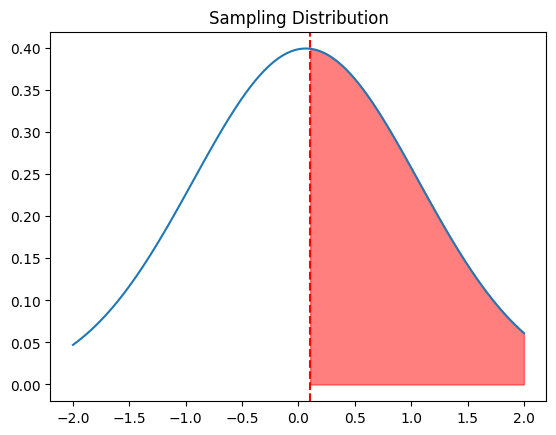

mu = 0.11352377613586609
p_h_hat = 0.23682707088962737
sigma=31.40799313575192
z-score: 0.0039
p-value: 0.5016


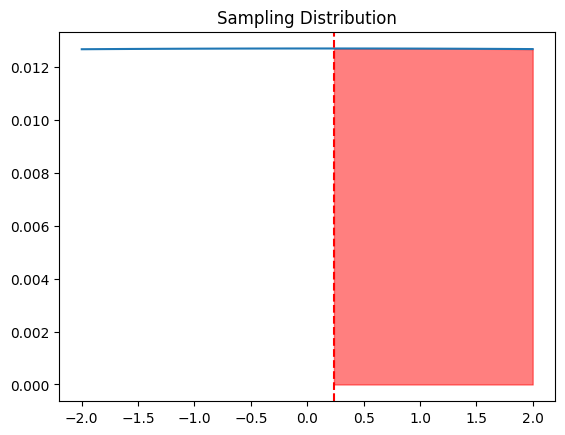

mu = 0.14934067445121985
p_h_hat = 0.2345585372823139
sigma=453.08578897503037
z-score: 0.0002
p-value: 0.5001


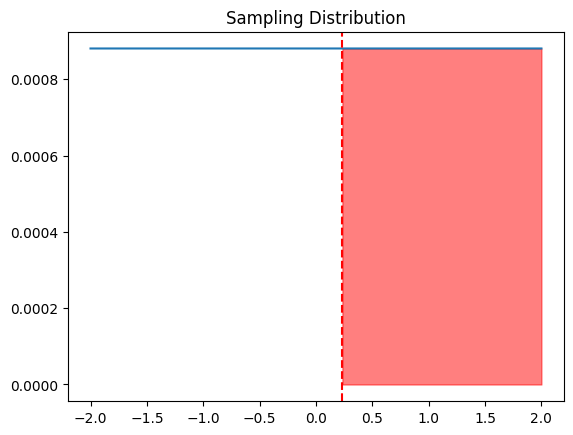

mu = 0.2247809135579454
p_h_hat = 0.3391811217312419
sigma=1288.43307617764
z-score: 0.0001
p-value: 0.5000


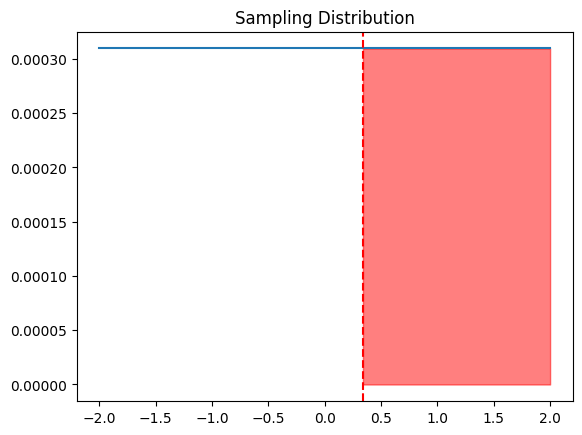

In [121]:
alpha = 0.05
p_values = {}
for i in range(len(p_halving_hat)):
    p_nh_hat = p_nonhalving_hat[i][0]
    p_nh_std = p_nonhalving_std[i][0]
    n_nh = p_nonhalving_hat[i][1]
    p_h_hat = p_halving_hat[i][0]
    p_h_std = p_halving_std[i][0]
    n_h = p_halving_hat[i][1]

    mu = p_nh_hat            # null hypothesis
    s = p_h_std
    n = n_h
    # sigma = s/np.sqrt(n)
    sigma = p_nh_std

    print(f'mu = {mu}')
    print(f'p_h_hat = {p_h_hat}')
    print(f'sigma={sigma}')
    z_score = (p_h_hat - mu)/sigma
    print(f'z-score: {z_score:.4f}', )
    print(f'p-value: {norm.cdf(z_score):.4f}')
    # Plot distribution of null hypothesis
    x = np.linspace(-2, 2, 100)
    plt.plot(x, norm.pdf(x, loc=mu, scale=sigma))
    plt.title('Sampling Distribution')

    plt.axvline(p_h_hat, c='red', linestyle='dashed')
    x_shade = np.arange(p_h_hat, 2, 0.001)
    plt.fill_between(x_shade, norm.pdf(x_shade, loc=mu, scale=sigma), color='red', alpha=0.5)

    plt.show()



Check among sub-sections in the non-halving regions

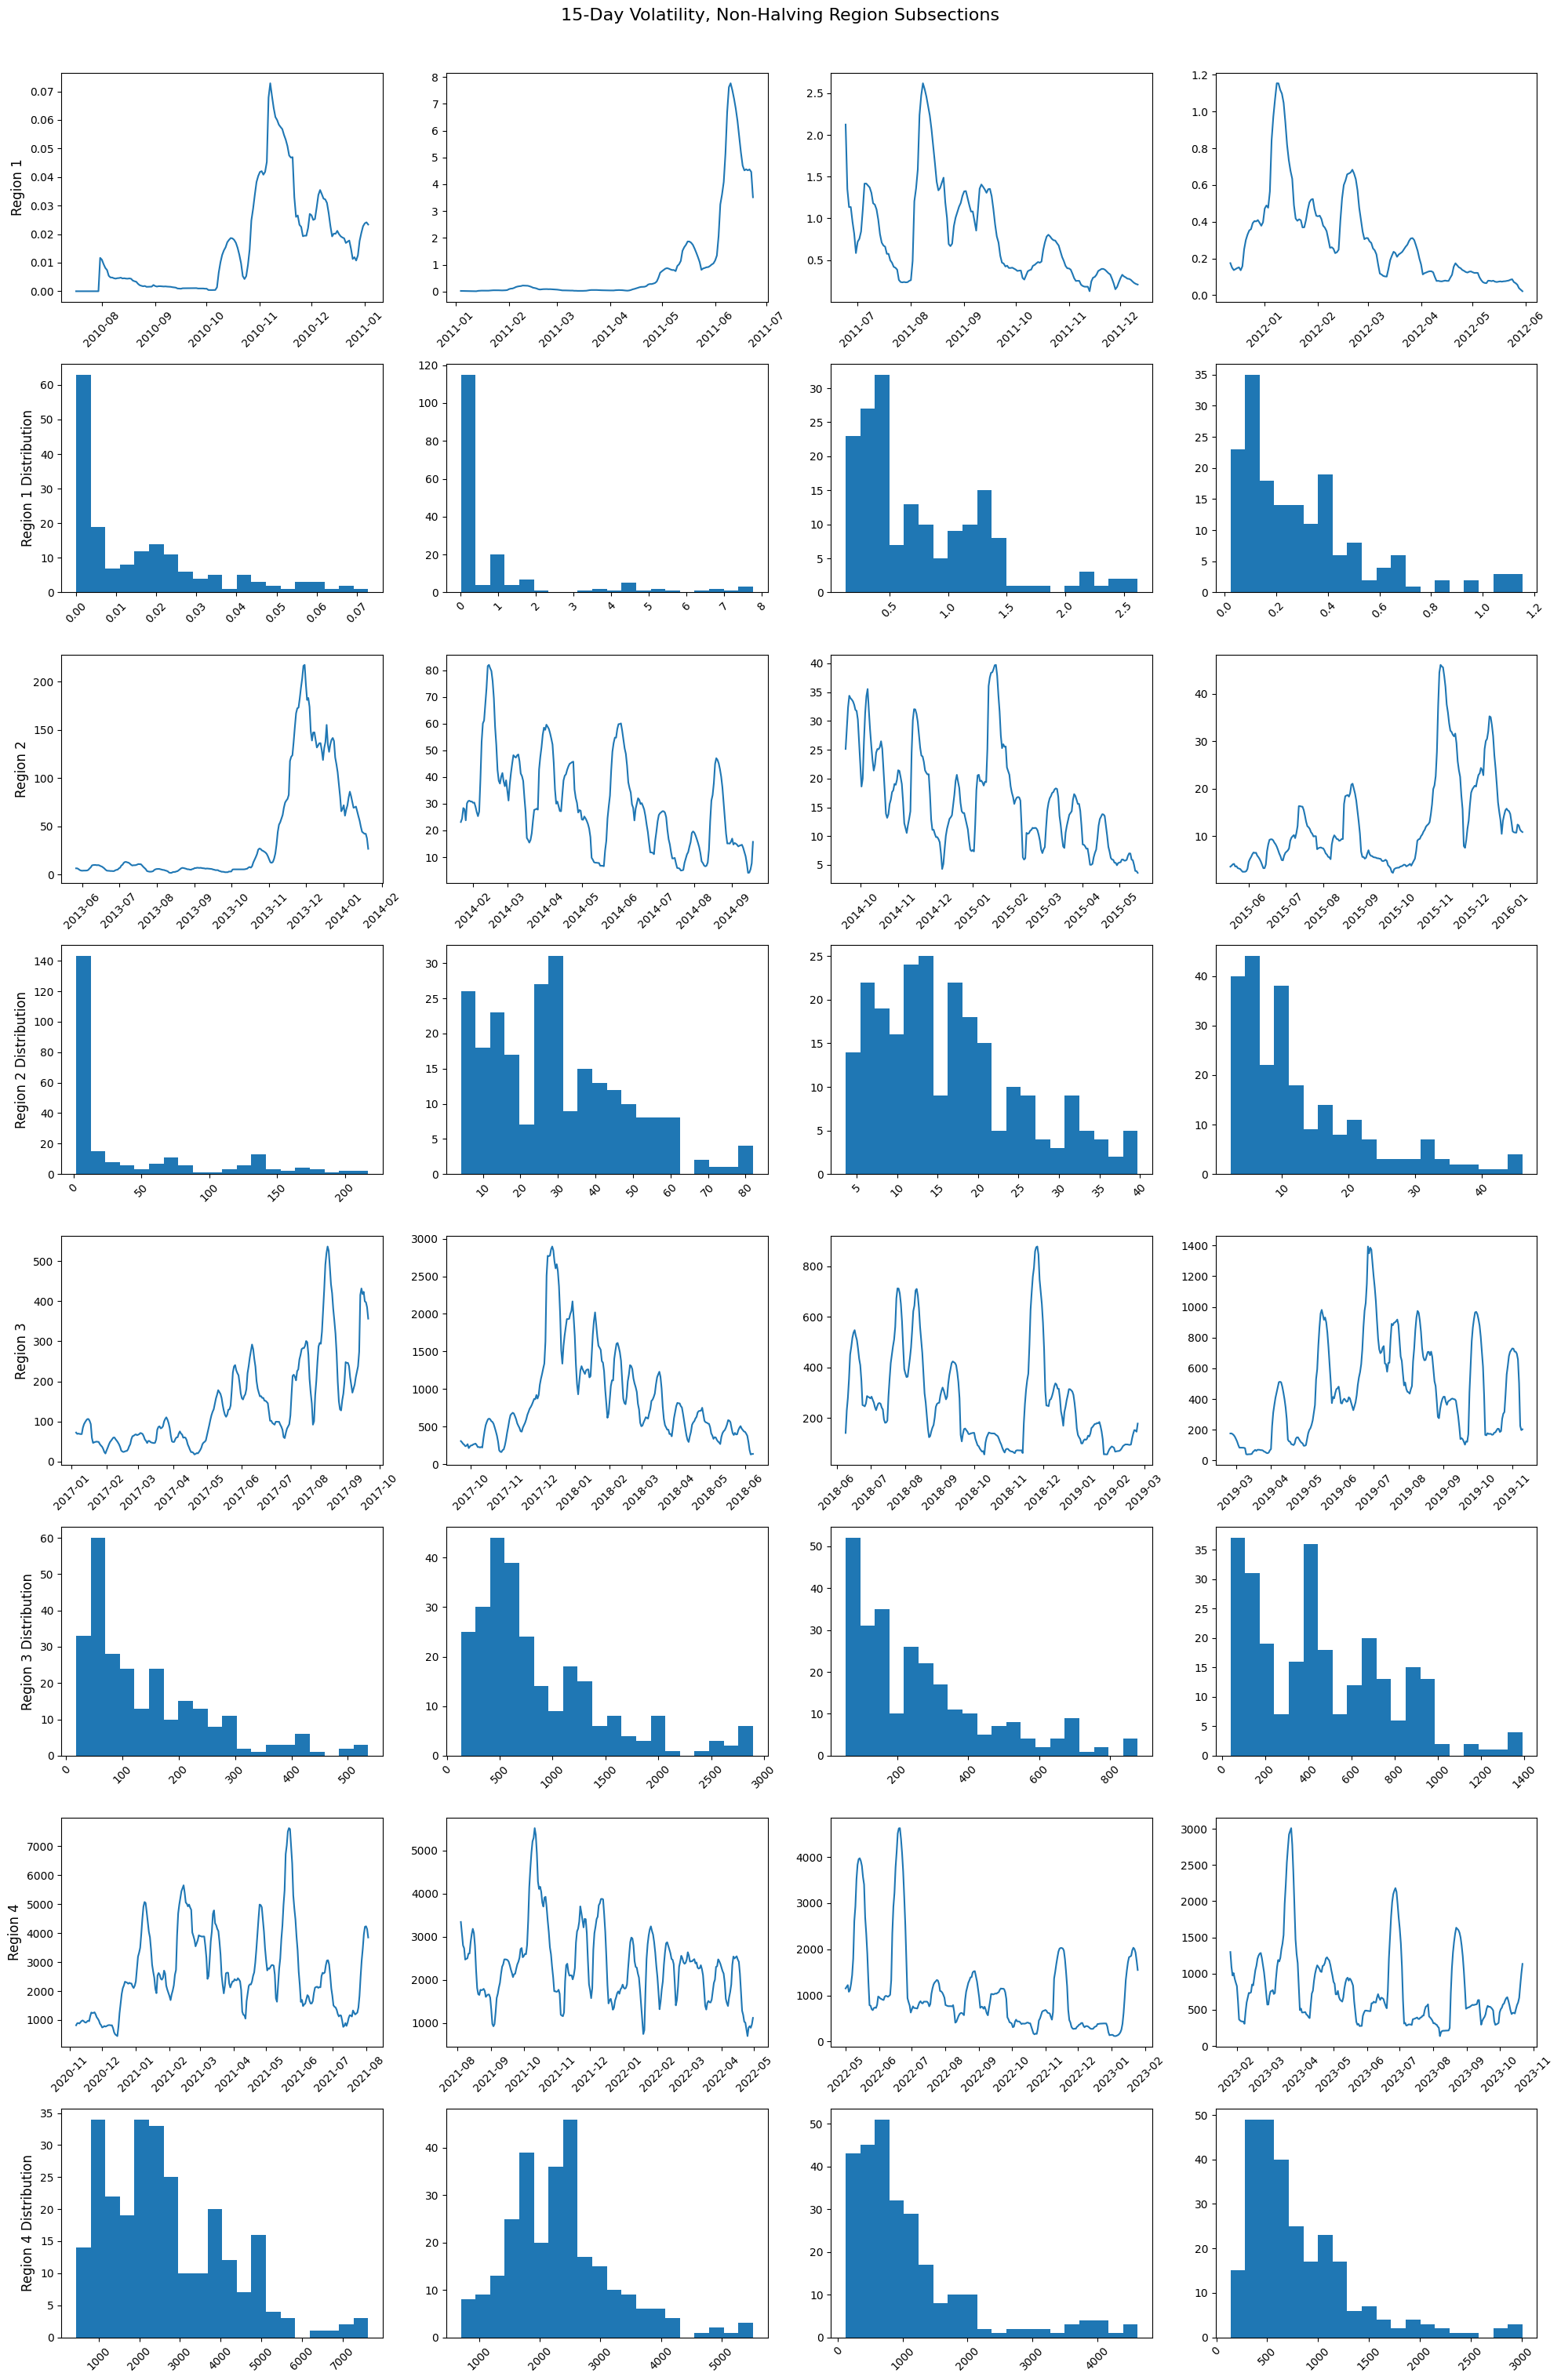

In [44]:
fig, ax = plt.subplots(8, 4, figsize=(20,30))
regions = []
for idx, region in enumerate(nonhalving_data):
    # divide region in to 4 subsections and compare them:
    size = math.floor(len(region.index)/4)
    subsections = []
    # print(len(region.index))
    # print(size)
    for i in range(4):
        subsections.append(region.iloc[i * size:(i+1)*size])
        # print(len(subsections[i].index))
        ax[idx * 2][i].plot(subsections[i]['std_15'])
        ax[idx * 2][i].tick_params(axis='x', labelrotation=45)
        ax[idx * 2][0].set_ylabel(f'Region {idx+1}', rotation=90, size='large')
        ax[idx * 2 + 1][i].hist(subsections[i]['std_15'], bins=20)
        ax[idx * 2 + 1][i].tick_params(axis='x', labelrotation=45)
        ax[idx * 2 + 1][0].set_ylabel(f'Region {idx+1} Distribution', rotation=90, size='large')
    regions.append(subsections)
    plt.tight_layout()
    fig.suptitle('15-Day Volatility, Non-Halving Region Subsections',fontsize=16, y=1.01)
    

Do the same Hypothesis Testing among these regions

In [141]:
sec_p_values = {}
alpha = 0.05
for idx, region in enumerate(regions):
    indices = itertools.combinations(region,2)
    for j, item in enumerate(indices):
        p_s1_hat = np.sum(item[0]['std_15'].to_numpy())/len(item[0].index)/item[0]['std_15'].max()
        n_s1 = len(item[0].index)
        p_s2_hat = np.sum(item[1]['std_15'].to_numpy())/len(item[1].index)/item[1]['std_15'].max()
        n_s2 = len(item[1].index)
        p_s1_std = np.std(item[0]['std_15'].to_numpy())
        p_s2_std = np.std(item[1]['std_15'].to_numpy())

        se = math.sqrt((p_s1_std ** 2) / n_s1 + (p_s2_std ** 2) / n_s2)

        z_score = (p_h_hat - p_nh_hat)/se 

        print(f'SE      = {se:.6f}')
        print(f'Z-score    = {z_score:.6f}')

        p_value = 1 - norm.cdf(abs(z_score),  loc=p_nh_hat, scale=se1)
        i = f'{idx}-{j}'
        sec_p_values[i]=p_value
        print(f'p-value = {p_value:.6f}')
        if p_value <= alpha:
            print(f'p-value less than alpha! Reject H0.\n\n')
        else:
            print(f'p-value greater than alpha! Cannot Reject H0.\n\n')
        

SE      = 0.134473
Z-score    = 0.850732
p-value = 0.000000
p-value less than alpha! Reject H0.


SE      = 0.042683
Z-score    = 2.680236
p-value = 0.000000
p-value less than alpha! Reject H0.


SE      = 0.019094
Z-score    = 5.991285
p-value = 0.000000
p-value less than alpha! Reject H0.


SE      = 0.141071
Z-score    = 0.810939
p-value = 0.000000
p-value less than alpha! Reject H0.


SE      = 0.135808
Z-score    = 0.842366
p-value = 0.000000
p-value less than alpha! Reject H0.


SE      = 0.046721
Z-score    = 2.448602
p-value = 0.000000
p-value less than alpha! Reject H0.


SE      = 3.712377
Z-score    = 0.030816
p-value = 1.000000
p-value greater than alpha! Cannot Reject H0.


SE      = 3.581816
Z-score    = 0.031939
p-value = 1.000000
p-value greater than alpha! Cannot Reject H0.


SE      = 3.592053
Z-score    = 0.031848
p-value = 1.000000
p-value greater than alpha! Cannot Reject H0.


SE      = 1.265699
Z-score    = 0.090385
p-value = 1.000000
p-value greater than alpha! 

Do Holm's Stepdown Procedure

In [140]:
# print(p_values)
df_sec_stat=pd.DataFrame()
df_sec_stat['region']=sec_p_values.keys()
df_sec_stat['p_value']=sec_p_values.values()
alpha = 0.05
df_sec_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_sec_stat['L_thresholds'] = alpha/(df_sec_stat.shape[0] + 1 - (np.arange(df_sec_stat.shape[0]) + 1)) 
df_sec_stat['reject'] = df_sec_stat['p_value'] < df_sec_stat['L_thresholds']
df_sec_stat.reset_index(drop=True, inplace=True)
print(df_sec_stat)
different = max(df_sec_stat.loc[df_sec_stat['reject'] == True].index +1)
not_different = len(df_sec_stat.index) - different
print(f'\nNon-Halving subsections that are not statistically different: {not_different/(different+not_different) * 100}%')

   region  p_value  L_thresholds  reject
0     0-0      0.0      0.002083    True
1     0-1      0.0      0.002174    True
2     0-2      0.0      0.002273    True
3     0-3      0.0      0.002381    True
4     0-4      0.0      0.002500    True
5     0-5      0.0      0.002632    True
6     1-5      1.0      0.002778   False
7     1-1      1.0      0.002941   False
8     3-3      1.0      0.003125   False
9     3-2      1.0      0.003333   False
10    3-1      1.0      0.003571   False
11    3-0      1.0      0.003846   False
12    2-5      1.0      0.004167   False
13    2-4      1.0      0.004545   False
14    1-0      1.0      0.005000   False
15    2-3      1.0      0.005556   False
16    2-1      1.0      0.006250   False
17    2-0      1.0      0.007143   False
18    3-4      1.0      0.008333   False
19    1-4      1.0      0.010000   False
20    1-3      1.0      0.012500   False
21    1-2      1.0      0.016667   False
22    2-2      1.0      0.025000   False
23    3-5      1

Analysis on Mean Price (Discard This Section)

Text(0.5, 0.98, '15-Day Mean Price')

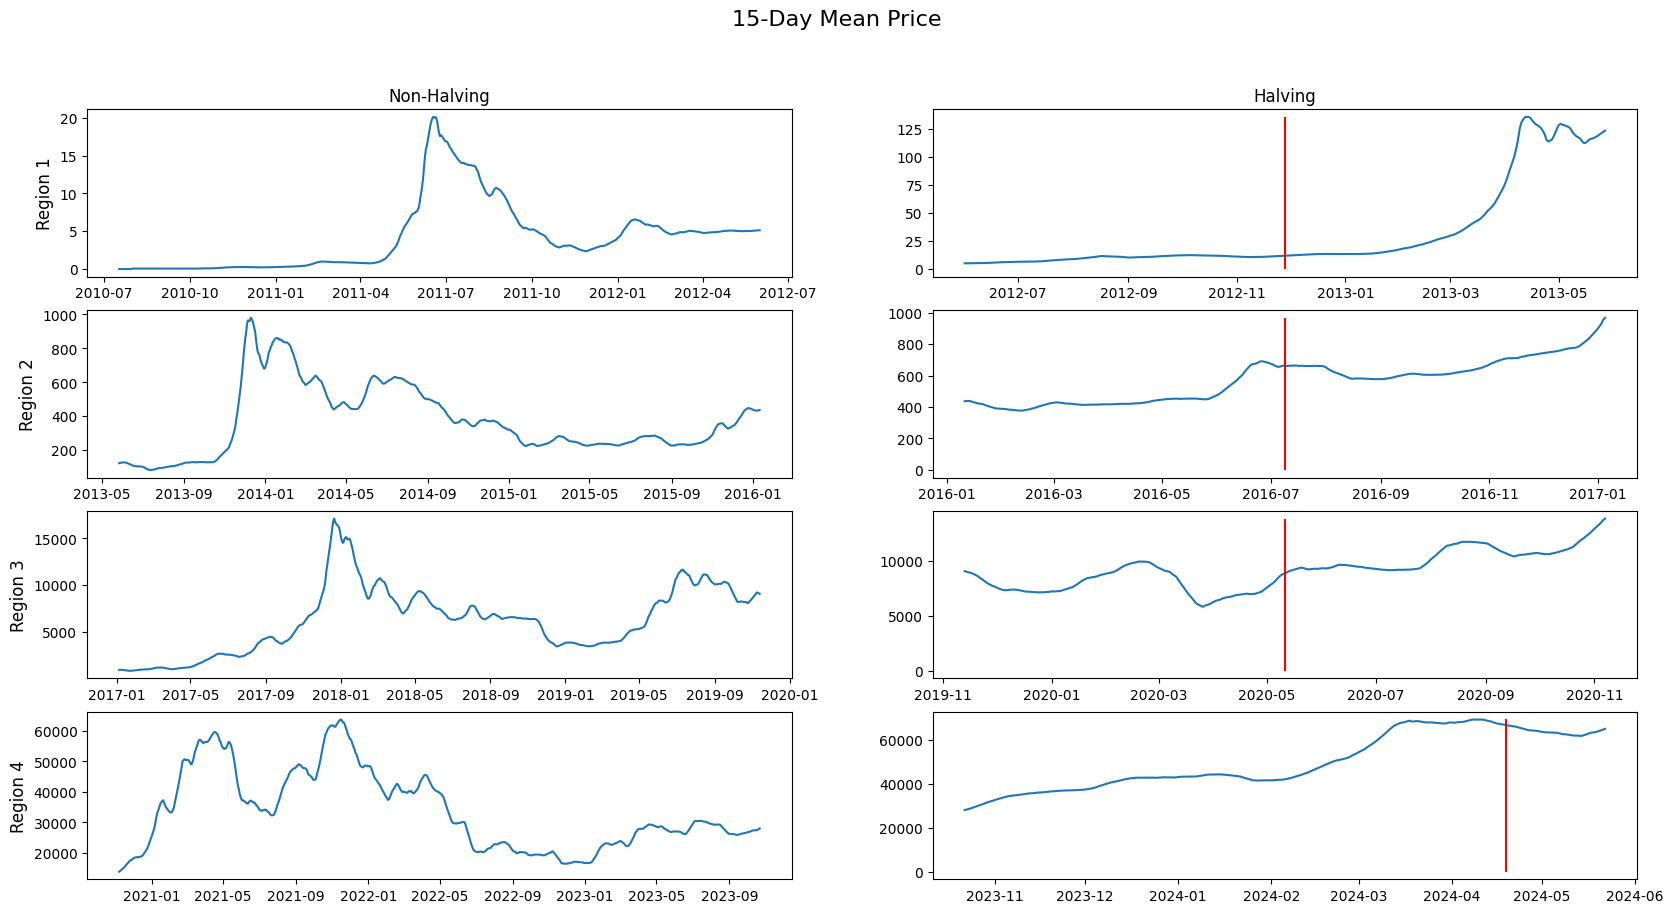

In [177]:
ctr = 1
fig, ax = plt.subplots(4,2, figsize=(20,10))
for nhd, hd in zip(nonhalving_data, halving_data):
    ax[ctr -1][0].plot(nhd['mean_15'])
    ax[ctr -1][1].plot(hd['mean_15'])
    ax[ctr -1][1].vlines(halving_dates[ctr - 1], 0, hd['mean_15'].max(), colors='r', label='Halving Date')
    ctr += 1
ax[0][0].set_title('Non-Halving')
ax[0][1].set_title('Halving')
for i in range(4):
    ax[i][0].set_ylabel(f'Region {i+1}', rotation=90, size='large')
fig.suptitle('15-Day Mean Price',fontsize=16)

Text(0.5, 0.98, '15-Day Mean Price Distribution')

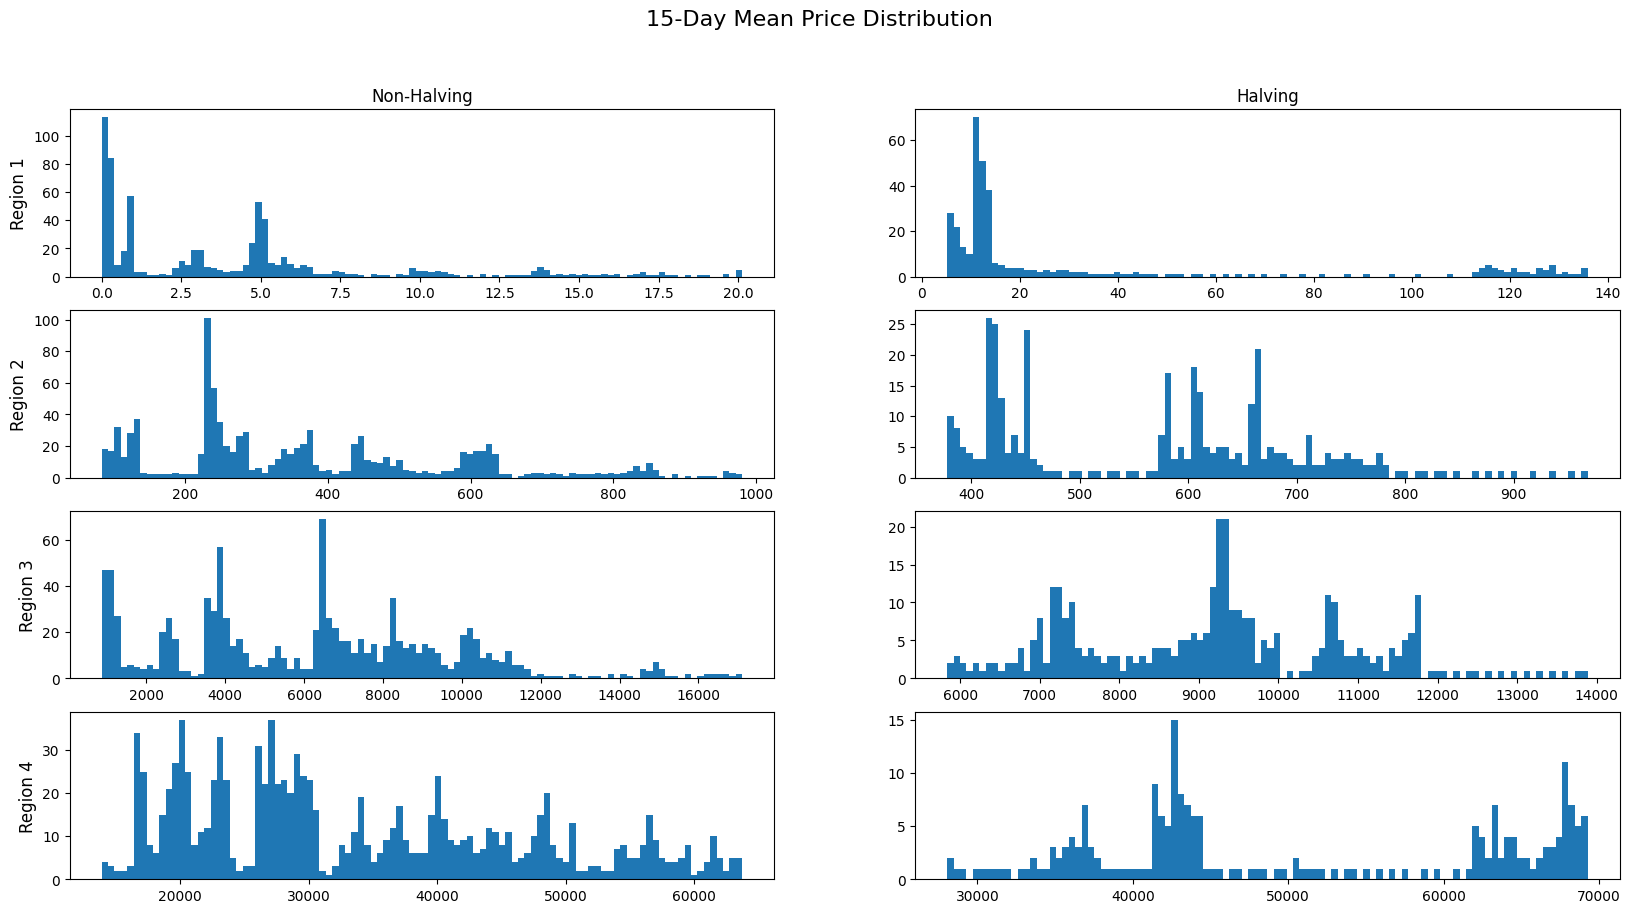

In [180]:
ctr = 1
fig, ax = plt.subplots(4,2, figsize=(20,10))
for nhd, hd in zip(nonhalving_data, halving_data):
    ax[ctr -1][0].hist(nhd['mean_15'], bins=100)
    ax[ctr -1][1].hist(hd['mean_15'], bins=100)
    ctr += 1
ax[0][0].set_title('Non-Halving')
ax[0][1].set_title('Halving')
for i in range(4):
    ax[i][0].set_ylabel(f'Region {i+1}', rotation=90, size='large')
fig.suptitle('15-Day Mean Price Distribution',fontsize=16)

A-B Testing Between Regions<br>
Alternative Hypothesis: The halvings have an effect on the 15-day mean price of BTC.<br>
Null Hypothesis: The halvings have no effect

In [157]:
p_halving_hat= []
p_nonhalving_hat = []

for item in halving_data:
    p_halving_hat.append((np.sum(item['mean_15'].to_numpy())/len(item.index)/item['mean_15'].max(),len(item.index)))

for item in nonhalving_data:
    p_nonhalving_hat.append((np.sum(item['mean_15'].to_numpy())/len(item.index)/item['mean_15'].max(),len(item.index)))

print(p_halving_hat)
print(p_nonhalving_hat)

[(0.23413647558944736, 361), (0.586318534010931, 361), (0.6614268318507764, 361), (0.7249694657746734, 214)]
[(0.20629399451847477, 686), (0.3771604146403535, 960), (0.36402678184338827, 1043), (0.5287309913402541, 1080)]


SE of Halving Data = 0.015461
SE of Nonhalving Data = 0.022318
Pooled SE      = 0.027150
t-Statistic    = 1.025498


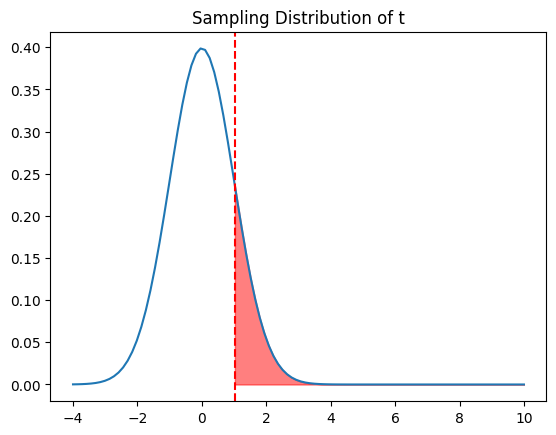

p-value = 0.152683
p-value greater than alpha! Cannot Reject H0.


SE of Halving Data = 0.015651
SE of Nonhalving Data = 0.025957
Pooled SE      = 0.030310
t-Statistic    = 6.900612


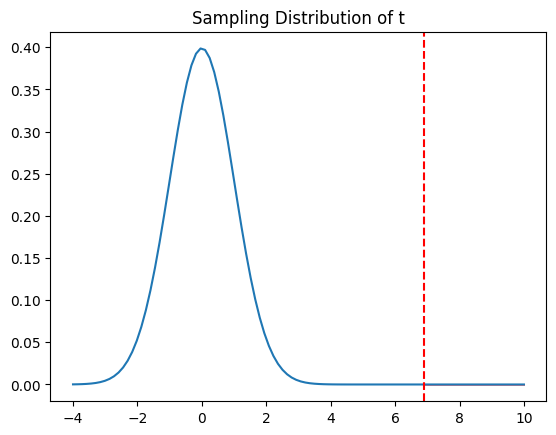

p-value = 0.000000
p-value less than alpha! Reject H0.


SE of Halving Data = 0.014906
SE of Nonhalving Data = 0.024941
Pooled SE      = 0.029056
t-Statistic    = 10.235482


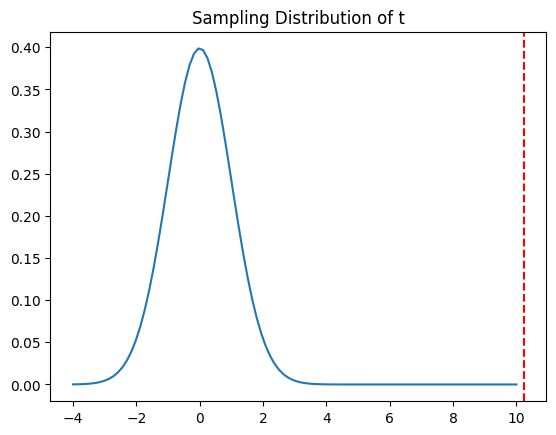

p-value = 0.000000
p-value less than alpha! Reject H0.


SE of Halving Data = 0.015196
SE of Nonhalving Data = 0.030596
Pooled SE      = 0.034162
t-Statistic    = 5.744384


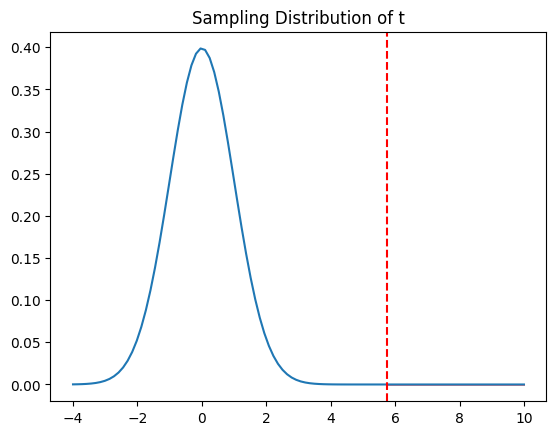

p-value = 0.000000
p-value less than alpha! Reject H0.




In [161]:
alpha = 0.05
p_values = {}
for i in range(len(p_halving_hat)):
    p_nh_hat = p_nonhalving_hat[i][0]
    n_nh = p_nonhalving_hat[i][1]
    p_h_hat = p_halving_hat[i][0]
    n_h = p_halving_hat[i][1]
    se1 = np.sqrt(p_nh_hat*(1-p_nh_hat)/(n_nh-1)) # Standard error of sample 1 (control group)
    se2 = np.sqrt(p_h_hat*(1-p_h_hat)/(n_h-1)) # Standard error of sample 1 (control group)
    pooled_se = np.sqrt(se1**2 + se2**2) # If we assume independent samples, the total variance is just the sum
    t_stat = (p_h_hat - p_nh_hat)/pooled_se # t-statistic (looks like a z-score but has t distribution instead of normal)
    print(f'SE of Halving Data = {se1:.6f}')
    print(f'SE of Nonhalving Data = {se2:.6f}')
    print(f'Pooled SE      = {pooled_se:.6f}')
    print(f't-Statistic    = {t_stat:.6f}')

    df = n_nh + n_h - 2 # Degrees of freedom, we subtract 2 because we used 2 estimates (se1 & se2)
                            # It is the number of values in the final calculation of a statistic that are free to vary

    # Plot distribution of null hypothesis
    x = np.linspace(-4, 10, 100)
    plt.plot(x, t.pdf(x, df))
    plt.title('Sampling Distribution of t')

    plt.axvline(t_stat, c='red', linestyle='dashed')
    x_shade = np.arange(t_stat, 10, 0.0001)
    plt.fill_between(x_shade, t.pdf(x_shade, df), color='red', alpha=0.5)

    plt.show()
    p_value = 1 - t.cdf(abs(t_stat), df)
    p_values[i]=p_value
    print(f'p-value = {p_value:.6f}')
    if p_value <= alpha:
        print(f'p-value less than alpha! Reject H0.\n\n')
    else:
        print(f'p-value greater than alpha! Cannot Reject H0.\n\n')

Holm's Step-Down Procedure

In [159]:
df_stat=pd.DataFrame()
df_stat['region']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
df_stat['reject'] = df_stat['p_value'] < df_stat['L_thresholds']
print(df_stat)

   region       p_value  L_thresholds  reject
2       2  0.000000e+00      0.012500    True
1       1  4.009015e-12      0.016667    True
3       3  5.745781e-09      0.025000    True
0       0  1.526828e-01      0.050000   False


We conclude that the halving had a statistically significant effect on mean price during the periods of the last 3 halvings.